In [1]:
%pip install pingouin scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


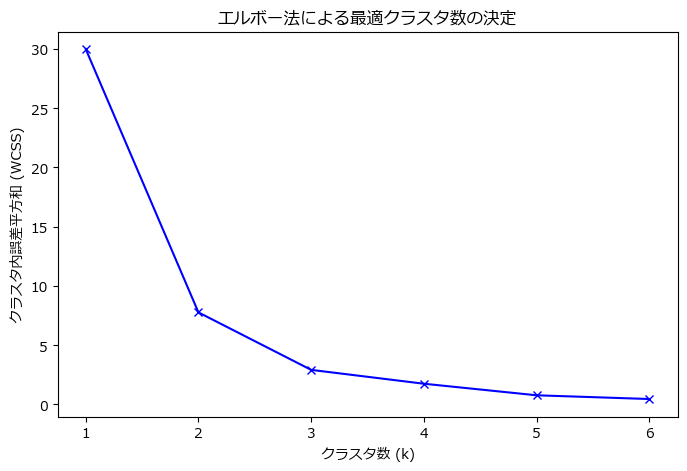


--- 各被験者のクラスタ分類結果 (k=2) ---
   subject  cluster
0        1        1
1        2        1
2        3        0
3        4        0
4        5        1
5        6        1
6        7        0
7        8        0
8        9        1
9       10        0


--- 各クラスタの平均値プロファイル ---
         subject  avg_oxy_hb  hrv_stress_index  gaze_stability  test_score  \
cluster                                                                      
0            6.4       0.058              30.0           0.954         9.4   
1            4.6       0.100              86.6           0.786         6.4   

         erq_score  
cluster             
0             6.26  
1             4.02  




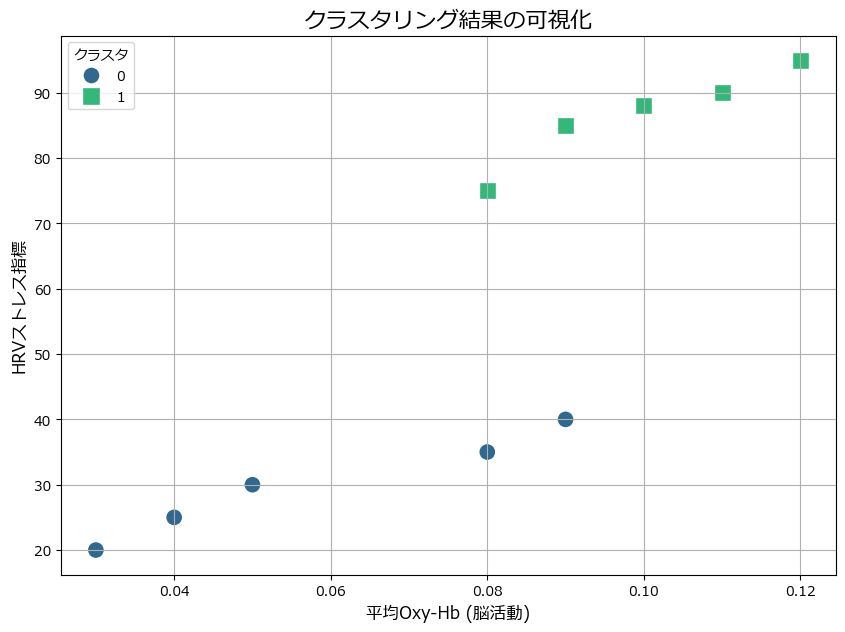

--- クラスタとテスト成績の関係 (ANOVA) ---
    Source  ddof1  ddof2       F     p-unc       np2
0  cluster      1      8  28.125  0.000725  0.778547


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Meiryo'

# --------------------------------------------------------------------------
# ステップ1: サンプルデータの作成
# --------------------------------------------------------------------------
# 実際のデータに置き換えてください。
# 被験者10人の「記憶課題」中のデータと、課題後の成績・アンケートスコアを想定。
data = pd.DataFrame({
    'subject': range(1, 11),
    # --- クラスタリングに使用する生体情報 ---
    'avg_oxy_hb':       [0.08, 0.09, 0.05, 0.04, 0.12, 0.11, 0.09, 0.03, 0.10, 0.08], # 脳血流（活動レベル）
    'hrv_stress_index': [75,   85,   30,   25,   95,   90,   40,   20,   88,   35],   # 心拍変動から算出したストレス指標（数値が高いほど高ストレス）
    'gaze_stability':   [0.9,  0.8,  0.95, 0.98, 0.7,  0.75, 0.92, 0.99, 0.78, 0.93], # 視線の安定性（数値が高いほど集中）
    # --- 解釈・検証に使う外部指標 ---
    'test_score':       [8,    7,    9,    10,   5,    6,    9,    10,   6,    9],    # テストの成績
    'erq_score':        [4.5,  4.2,  6.1,  6.5,  3.5,  3.8,  5.9,  6.8,  4.1,  6.0]   # ERQアンケートのスコア
})

# クラスタリングに使う特徴量を選択
features = data[['avg_oxy_hb', 'hrv_stress_index', 'gaze_stability']]


# --------------------------------------------------------------------------
# ステップ2: データ標準化
# --------------------------------------------------------------------------
# 各特徴量のスケールを揃える（平均0, 標準偏差1に変換）
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# --------------------------------------------------------------------------
# ステップ3: 最適クラスタ数(k)の決定（エルボー法）
# --------------------------------------------------------------------------
distortions = []
K = range(1, 7)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeanModel.fit(features_scaled)
    distortions.append(kmeanModel.inertia_) # inertia_ はクラスタ内誤差平方和

# エルボープロットを描画
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('クラスタ数 (k)')
plt.ylabel('クラスタ内誤差平方和 (WCSS)')
plt.title('エルボー法による最適クラスタ数の決定')
plt.show()
# グラフの「肘（エルボー）」のように急激な低下が緩やかになる点が最適なkの候補（このデータでは2か3）


# --------------------------------------------------------------------------
# ステップ4: k-meansクラスタリングの実行
# --------------------------------------------------------------------------
# エルボー法の結果から、クラスタ数を k=2 として決定
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(features_scaled)

# 元のデータにクラスタリング結果を追加
data['cluster'] = clusters


# --------------------------------------------------------------------------
# ステップ5: 結果の解釈と検証
# --------------------------------------------------------------------------
print(f"\n--- 各被験者のクラスタ分類結果 (k={k}) ---")
print(data[['subject', 'cluster']])
print("\n" + "="*50 + "\n")


# --- 5-1. 各クラスタの特徴を分析 ---
print("--- 各クラスタの平均値プロファイル ---")
cluster_profile = data.groupby('cluster').mean()
print(cluster_profile)
print("\n" + "="*50 + "\n")


# --- 5-2. 結果の可視化 ---
# 例として、脳活動とストレス指標の2軸で散布図を作成
plt.figure(figsize=(10, 7))
sns.scatterplot(data=data, x='avg_oxy_hb', y='hrv_stress_index', hue='cluster', 
                palette='viridis', s=150, style='cluster', markers=['o', 's'])
plt.title('クラスタリング結果の可視化', fontsize=16)
plt.xlabel('平均Oxy-Hb (脳活動)', fontsize=12)
plt.ylabel('HRVストレス指標', fontsize=12)
plt.legend(title='クラスタ')
plt.grid(True)
plt.show()


# --- 5-3. 外部指標（成績）との関連を検証 ---
print("--- クラスタとテスト成績の関係 (ANOVA) ---")
# クラスタ間でテストの成績に有意な差があるかを検定
aov_score = pg.anova(data=data, dv='test_score', between='cluster')
print(aov_score)

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg


In [4]:

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Meiryo'

# --------------------------------------------------------------------------
# ステップ1: サンプルデータの作成
# --------------------------------------------------------------------------
# 実際のデータに置き換えてください。
# 被験者10人の「記憶課題」中のデータと、課題後の成績・アンケートスコアを想定。
""" data = pd.DataFrame({
    'subject': range(1, 11),
    # --- クラスタリングに使用する生体情報 ---
    'avg_oxy_hb':       [0.08, 0.09, 0.05, 0.04, 0.12, 0.11, 0.09, 0.03, 0.10, 0.08], # 脳血流（活動レベル）
    'hrv_stress_index': [75,   85,   30,   25,   95,   90,   40,   20,   88,   35],   # 心拍変動から算出したストレス指標（数値が高いほど高ストレス）
    'gaze_stability':   [0.9,  0.8,  0.95, 0.98, 0.7,  0.75, 0.92, 0.99, 0.78, 0.93], # 視線の安定性（数値が高いほど集中）
    # --- 解釈・検証に使う外部指標 ---
    'test_score':       [8,    7,    9,    10,   5,    6,    9,    10,   6,    9],    # テストの成績
    'erq_score':        [4.5,  4.2,  6.1,  6.5,  3.5,  3.8,  5.9,  6.8,  4.1,  6.0]   # ERQアンケートのスコア
}) """
# data = pd.read_excel("E:/Je respire/解析/1. 脳血流と問題カテゴリの関連.xlsx", sheet_name='ディアビアイ',
#                      usecols=range(0, 28))  #
# data = data.drop(columns=['left_pupil_std', 'right_pupil_std']) # 脳血流だけ

data = pd.read_excel("E:/Je respire/解析/1. 脳血流と問題カテゴリの関連.xlsx", sheet_name='ディアビアイ',
                     usecols=range(0, 6))  #視線
data = data.iloc[:216, :]  # 視線の最後の欠損を排除
data["left_pupil_std"][168] = 1/5 * (data["left_pupil_std"][170] + data["left_pupil_std"][173] + data["left_pupil_std"][178] + data["left_pupil_std"][181] + data["left_pupil_std"][191])
data["right_pupil_std"][168] = 1/5 * (data["right_pupil_std"][170] + data["right_pupil_std"][173] + data["right_pupil_std"][178] + data["right_pupil_std"][181] + data["right_pupil_std"][191])
# data = data.drop(columns=['left_pupil_std', 'right_pupil_std']) # 脳血流だけ

# クラスタリングに使う特徴量を選択
""" features = data[['avg_oxy_hb', 'hrv_stress_index', 'gaze_stability']] """
features = data.iloc[:, 4:]  # 例として、6列目から28列目までのデータを使用


""" # --------------------------------------------------------------------------
# ステップ2: データ標準化
# --------------------------------------------------------------------------
# 各特徴量のスケールを揃える（平均0, 標準偏差1に変換）
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features) """


C:\Users\thisi\AppData\Local\Temp\ipykernel_32012\955043763.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["left_pupil_std"][168] = 1/5 * (data["left_pupil_std"][170] + data["left_pupil_std"][173] + data["left_pupil_std"][178] + d

' # --------------------------------------------------------------------------\n# ステップ2: データ標準化\n# --------------------------------------------------------------------------\n# 各特徴量のスケールを揃える（平均0, 標準偏差1に変換）\nscaler = StandardScaler()\nfeatures_scaled = scaler.fit_transform(features) '

In [12]:
# 日本語フォントの設定
plt.rcParams['font.family'] = 'Meiryo'

data = pd.read_excel("E:/Je respire/解析/1.2 脳血流と問題カテゴリの関連 - 背外側追加.xlsx", sheet_name='ディアビアイ')

# 視線の欠損1データを補完
data["left_pupil_std"][168] = 1/5 * (data["left_pupil_std"][170] + data["left_pupil_std"][173] + data["left_pupil_std"][178] + data["left_pupil_std"][181] + data["left_pupil_std"][191])
data["right_pupil_std"][168] = 1/5 * (data["right_pupil_std"][170] + data["right_pupil_std"][173] + data["right_pupil_std"][178] + data["right_pupil_std"][181] + data["right_pupil_std"][191])
# data = data.drop(columns=['left_pupil_std', 'right_pupil_std']) # 脳血流だけ

# 使う行、列を指定
data = data.iloc[24:216, :].reset_index(drop=True)  # 視線の最後の欠損を排除
data = data.drop(columns=['sheet_name', 'dataset_no', 
    'CH1.1_std', 'CH2.1_std', 'CH3.1_std', 'CH4.1_std', 'CH5.1_std', 'CH6.1_std',
    'CH7.1_std', 'CH8.1_std', 'CH9.1_std', 'CH10.1_std', 'CH11.1_std',
    'CH12.1_std', 'CH13.1_std', 'CH14.1_std', 'CH15.1_std', 'CH16.1_std',
    'CH17.1_std', 'CH18.1_std', 'CH19.1_std', 'CH20.1_std', 'CH21.1_std',
    'CH22.1_std', 'CH1.2_std', 'CH2.2_std', 'CH3.2_std', 'CH4.2_std', 'CH5.2_std',
    'CH6.2_std', 'CH7.2_std', 'CH8.2_std', 'CH9.2_std', 'CH10.2_std',
    'CH11.2_std', 'CH12.2_std', 'CH13.2_std', 'CH14.2_std', 'CH15.2_std',
    'CH16.2_std', 'CH17.2_std', 'CH18.2_std', 'CH19.2_std', 'CH20.2_std',
    'CH21.2_std', 'CH22.2_std',
    ])  # 不要な列を削除

# data = data.drop(columns=['sheet_name', 'dataset_no', 'CH1.1_std', 'CH1.2_std'])  # 不要な列を削除

# クラスタリングに使う特徴量を選択
""" features = data[['avg_oxy_hb', 'hrv_stress_index', 'gaze_stability']] """
# features = data.iloc[:, 4:]  # 例として、6列目から28列目までのデータを使用
features_3brain = data[['hainai', 'left_haigai', 'right_haigai']]
features_hihumyaku = data[['Sensor-E:SC/GSR_std', 'Sensor-G:BVP_std', '[G] BVP Amp._std',
    '[G] Heart Rate_std', '[G] HRV Amp._std',
    '[G] HRV-LF Power (0,04-0,16 Hz)_std',
    '[G] HRV-HF Power (0,16-0,4 Hz)_std', '[G] HRV-LF / HRV-HF _std']]
features_gaze = data[['left_pupil_std', 'right_pupil_std']]

# features = data[['left_pupil_std', 'right_pupil_std', 'Sensor-E:SC/GSR_std', 'Sensor-G:BVP_std', '[G] BVP Amp._std',
#     '[G] Heart Rate_std', '[G] HRV Amp._std',
#     '[G] HRV-LF Power (0,04-0,16 Hz)_std',
#     '[G] HRV-HF Power (0,16-0,4 Hz)_std', '[G] HRV-LF / HRV-HF _std','hainai', 'left_haigai', 'right_haigai']]
features = features_3brain
# data = data[['subject', 'question', 'q_category', 'score', 'hainai', 'left_haigai', 'right_haigai']]

C:\Users\thisi\AppData\Local\Temp\ipykernel_32012\4252180910.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["left_pupil_std"][168] = 1/5 * (data["left_pupil_std"][170] + data["left_pupil_std"][173] + data["left_pupil_std"][178] + d

In [13]:
missing_cols = data.columns[data.isnull().any()]
print(missing_cols)


Index([], dtype='object')


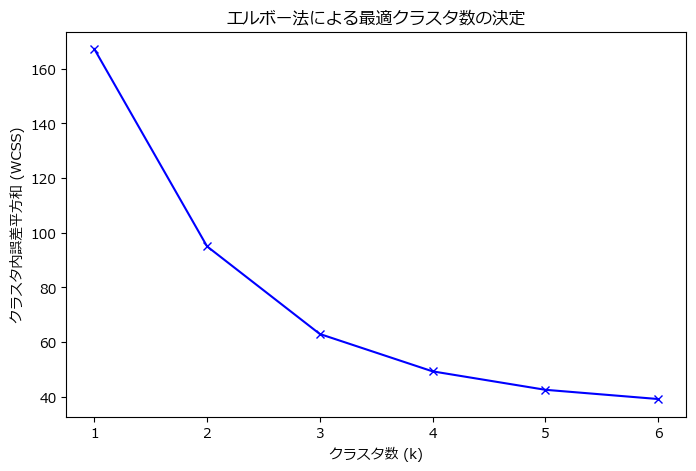

In [14]:


# --------------------------------------------------------------------------
# ステップ3: 最適クラスタ数(k)の決定（エルボー法）
# --------------------------------------------------------------------------
distortions = []
K = range(1, 7)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeanModel.fit(features)
    distortions.append(kmeanModel.inertia_) # inertia_ はクラスタ内誤差平方和

# エルボープロットを描画
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('クラスタ数 (k)')
plt.ylabel('クラスタ内誤差平方和 (WCSS)')
plt.title('エルボー法による最適クラスタ数の決定')
plt.show()
# グラフの「肘（エルボー）」のように急激な低下が緩やかになる点が最適なkの候補（このデータでは2か3）


In [19]:


# --------------------------------------------------------------------------
# ステップ4: k-meansクラスタリングの実行
# --------------------------------------------------------------------------
# エルボー法の結果から、クラスタ数を k=2 として決定
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(features)

# 元のデータにクラスタリング結果を追加
data['cluster'] = clusters


In [20]:
data.columns

Index(['subject', 'question', 'q_category', 'score', 'left_pupil_std',
       'right_pupil_std', 'CH1_std', 'CH2_std', 'CH3_std', 'CH4_std',
       'CH5_std', 'CH6_std', 'CH7_std', 'CH8_std', 'CH9_std', 'right_haigai',
       'CH10_std', 'CH11_std', 'CH12_std', 'CH13_std', 'hainai', 'CH14_std',
       'CH15_std', 'CH16_std', 'CH17_std', 'CH18_std', 'left_haigai',
       'CH19_std', 'CH20_std', 'CH21_std', 'CH22_std', 'Sensor-E:SC/GSR_std',
       'Sensor-G:BVP_std', '[G] BVP Amp._std', '[G] Heart Rate_std',
       '[G] HRV Amp._std', '[G] HRV-LF Power (0,04-0,16 Hz)_std',
       '[G] HRV-HF Power (0,16-0,4 Hz)_std', '[G] HRV-LF / HRV-HF _std',
       'cluster'],
      dtype='object')


--- 各被験者のクラスタ分類結果 (k=3) ---
     subject  cluster
0          2        0
1          2        1
2          2        0
3          2        1
4          2        1
..       ...      ...
187       10        0
188       10        0
189       10        1
190       10        1
191       10        0

[192 rows x 2 columns]


--- 各クラスタの平均値プロファイル ---
          subject   question  q_category     score  left_pupil_std  \
cluster                                                              
0        5.846154  13.444444    2.658120  1.222222        0.050816   
1        6.069767  11.790698    2.395349  1.395349       -0.040586   
2        4.968750  10.000000    2.062500  1.375000       -0.097799   

         right_pupil_std   CH1_std   CH2_std   CH3_std   CH4_std  ...  \
cluster                                                           ...   
0               0.006994  0.143140  0.072108 -0.004634  0.092742  ...   
1              -0.095491  0.067063 -0.021398 -0.400013 -0.349304  ...   
2             

C:\Users\thisi\AppData\Local\Temp\ipykernel_32012\2938481262.py:21: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=data, x='left_haigai', y='right_haigai', hue='cluster',


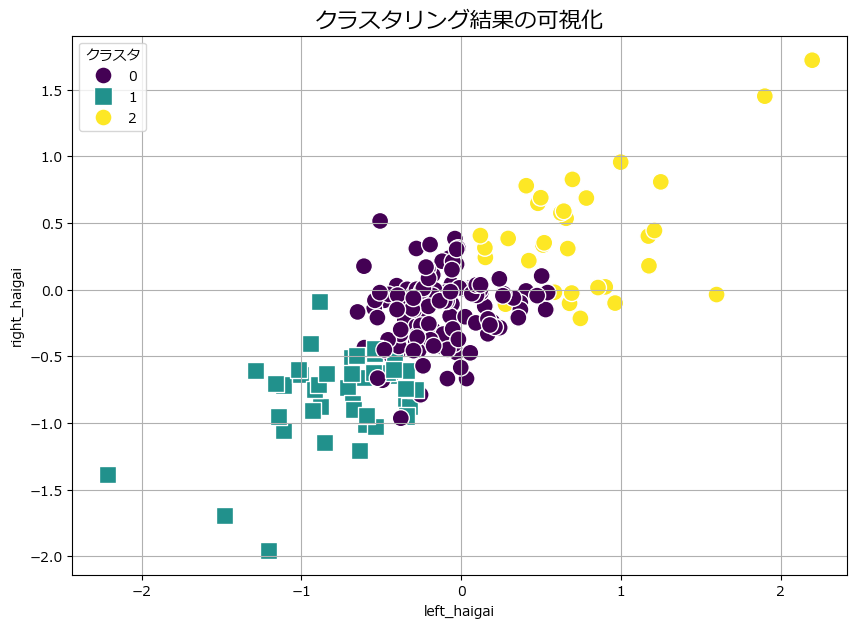

In [21]:


# --------------------------------------------------------------------------
# ステップ5: 結果の解釈と検証
# --------------------------------------------------------------------------
print(f"\n--- 各被験者のクラスタ分類結果 (k={k}) ---")
print(data[['subject', 'cluster']])
print("\n" + "="*50 + "\n")


# --- 5-1. 各クラスタの特徴を分析 ---
print("--- 各クラスタの平均値プロファイル ---")
cluster_profile = data.groupby('cluster').mean()
print(cluster_profile)
print("\n" + "="*50 + "\n")


# --- 5-2. 結果の可視化 ---
# 例として、脳活動とストレス指標の2軸で散布図を作成
plt.figure(figsize=(10, 7))
# sns.scatterplot(data=data, x='left_pupil_std', y='right_pupil_std', hue='cluster', 
#                 palette='viridis', s=150, style='cluster', markers=['o', 's'])
sns.scatterplot(data=data, x='left_haigai', y='right_haigai', hue='cluster', 
                palette='viridis', s=150, style='cluster', markers=['o', 's'])
plt.title('クラスタリング結果の可視化', fontsize=16)
# plt.xlabel('被験者', fontsize=12)
# plt.ylabel('クエスチョンカテゴリ', fontsize=12)
plt.legend(title='クラスタ')
plt.grid(True)
plt.show()


In [22]:
# --- 5-3. 外部指標（成績）との関連を検証 ---
print("--- クラスタとテスト成績の関係 (ANOVA) subject, question, q_category, score ---")
# クラスタ間でテストの成績に有意な差があるかを検定
aov_score = pg.anova(data=data, dv='subject', between='cluster')
print(aov_score, "\n")
aov_score = pg.anova(data=data, dv='question', between='cluster')
print(aov_score, "\n")
aov_score = pg.anova(data=data, dv='q_category', between='cluster')
print(aov_score, "\n")
aov_score = pg.anova(data=data, dv='score', between='cluster')
print(aov_score, "\n")

--- クラスタとテスト成績の関係 (ANOVA) subject, question, q_category, score ---
    Source  ddof1  ddof2         F     p-unc       np2
0  cluster      2    189  1.808295  0.166758  0.018776 

    Source  ddof1  ddof2         F     p-unc       np2
0  cluster      2    189  3.471545  0.033064  0.035434 

    Source  ddof1  ddof2         F     p-unc       np2
0  cluster      2    189  3.903821  0.021811  0.039671 

    Source  ddof1  ddof2         F    p-unc       np2
0  cluster      2    189  0.734436  0.48114  0.007712 

